<a href="https://colab.research.google.com/github/Anikxttt/M516-BusinessProject-GH1031696/blob/main/M516GH1031696.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

M516 BUSINESS PROJECT IN BIG DATA & AI

Personalised recommender system

Dataset link: https://archive.ics.uci.edu/dataset/502/online+retail+ii

Dataset has been downloaded and used under a creative commons 4.0 open license.



In [ ]:
#Importing the necessary libraries for the system
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import ndcg_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Data loading and cleaning
ord = pd.read_excel("online_retail_II.xlsx")
ord = ord[ord['Customer ID'].notnull()].copy()
ord = ord[~ord['Invoice'].astype(str).str.startswith('C')]
ord = ord[(ord['Quantity'] > 0) & (ord['Price'] > 0)]
ord['Customer ID'] = ord['Customer ID'].astype(int)
ord['Item'] = ord['Description'].str.strip().str.lower()
ord['TotalSum'] = ord['Quantity'] * ord['Price']
ord['InvoiceDate'] = pd.to_datetime(ord['InvoiceDate'])
#Removal of duplicates
ord = ord.drop_duplicates()
ord.info()
ord.head()

<class 'pandas.core.frame.DataFrame'>
Index: 400916 entries, 0 to 525460
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400916 non-null  object        
 1   StockCode    400916 non-null  object        
 2   Description  400916 non-null  object        
 3   Quantity     400916 non-null  int64         
 4   InvoiceDate  400916 non-null  datetime64[ns]
 5   Price        400916 non-null  float64       
 6   Customer ID  400916 non-null  int64         
 7   Country      400916 non-null  object        
 8   Item         400916 non-null  object        
 9   TotalSum     400916 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 33.6+ MB


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Item,TotalSum
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,15cm christmas glass ball 20 lights,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,pink cherry lights,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,white cherry lights,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,"record frame 7"" single size",100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,strawberry ceramic trinket box,30.0


In [ ]:
#Time based dataset split, added recency for time structure
cutoff = ord['InvoiceDate'].quantile(0.8)
ord_train = ord[ord['InvoiceDate'] <= cutoff]
ord_test = ord[ord['InvoiceDate'] > cutoff]

#Creating a user-item matrices system with item filtering
min_purchases = 3  # Items must be purchased at least 3 times
bskt_wtd = ord_train.groupby(['Customer ID', 'Item'])['Quantity'].sum().unstack().fillna(0)
bskt_bin = (bskt_wtd > 0).astype(int)
bskt_bin = bskt_bin.loc[:, bskt_bin.sum() >= min_purchases]  # Filter rare items

#Creating a user similarity matrix with more neighbors
knn_mdl = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=50, n_jobs=-1)
knn_mdl.fit(bskt_bin)
sim_matrix = knn_mdl.kneighbors_graph(mode='connectivity').toarray()
np.fill_diagonal(sim_matrix, 0)
sim_ord = pd.DataFrame(sim_matrix, index=bskt_bin.index, columns=bskt_bin.index)

In [ ]:
#Building the recommender systems
pop = ord_train.groupby('Item')['Quantity'].sum().sort_values(ascending=False)

def recommend_pop(user, k=5):
    return pop.head(k).index.tolist()

def recommend_ub(user, k=5):
    if user not in bskt_bin.index:
        return recommend_pop(user, k)

    #the top 20 users called to increase neighbourhood
    sim_users = sim_ord[user].nlargest(21).index[1:]

    #calculating weighted scores for the baskets
    user_sim = sim_ord.loc[user, sim_users]
    scores = bskt_bin.loc[sim_users].multiply(user_sim, axis=0).sum()

    #getting rid of items that are already purchased
    bought = bskt_bin.loc[user]
    scores = scores[(bought == 0) & (scores > 0)]

    #Fallback to popularity
    if len(scores) >= k:
        return scores.nlargest(k).index.tolist()
    else:
        #Blending the result with popular items
        num_needed = k - len(scores)
        pop_recs = pop.index[~pop.index.isin(scores.index)][:num_needed].tolist()
        return scores.index.tolist() + pop_recs

#Content-based system setup
items = ord_train[['Item']].drop_duplicates()
tfidf = TfidfVectorizer(min_df=3, stop_words='english')
tfidf_matrix = tfidf.fit_transform(items['Item'])
cos_t = cosine_similarity(tfidf_matrix, tfidf_matrix)
idx = {itm: i for i, itm in enumerate(items['Item'])}

def recommend_hybrid(user, k=5):
    if user not in bskt_bin.index:
        return recommend_pop(user, k)

    #Recommendations for collaborative filtering system
    collab_recs = recommend_ub(user, k*2)

    # Content-based similarity building
    expanded_recs = set(collab_recs)
    content_scores = {}

    for item in collab_recs:
        if item in idx:
            #Top 3 similar items in a list
            sim_scores = list(enumerate(cos_t[idx[item]]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:4]

            for pos, score in sim_scores:
                similar_item = items.iloc[pos]['Item']
                #max similarity according to item
                if similar_item in content_scores:
                    if score > content_scores[similar_item]:
                        content_scores[similar_item] = score
                else:
                    content_scores[similar_item] = score
                expanded_recs.add(similar_item)

    #Combining the data points
    combined_recs = list(expanded_recs)
    #Rank items
    ranked_recs = sorted(combined_recs,
                         key=lambda x: content_scores.get(x, 0),
                         reverse=True)[:k]

    return ranked_recs[:k]

In [ ]:
#Evaluation metrics to understand the system
def evaluate_model(model, sample_users, k=5):
    precision = recall = ndcg = hit = 0
    users = 0
    rec_items = set()
    diversities = []

    for u in sample_users:
        true = ord_test[ord_test['Customer ID'] == u]['Item'].unique().tolist()
        pred = model(u, k)

        if not true or not pred:
            continue

        #Conversion for binary relevance
        rel_true = [1 if i in true else 0 for i in pred]

        #Normalize for clean matching
        true = [str(i).strip().lower() for i in true]
        pred = [str(i).strip().lower() for i in pred]

        #Calculate binary relevance
        rel_true = [1 if i in true else 0 for i in pred]

        #Increment hit if there's any match
        if any(rel_true):
            hit += 1

        #using NDCG for evaluation
        try:
            ndcg += ndcg_score([rel_true], [np.arange(k)], k=k)
        except:
            pass

        #tracking recommended items
        users += 1
        rec_items |= set(pred)

        #Diversity calculation
        if len(pred) > 1:
            #Content system indices
            rec_indices = [idx[item] for item in pred if item in idx]

            if len(rec_indices) > 1:
                #Vectors assigned to recommended items
                rec_vectors = tfidf_matrix[rec_indices]

                #Pairwise cosine distances
                dist_matrix = pairwise_distances(rec_vectors, metric='cosine')

                #Calculate of diversity (Average distance)
                upper_triangle = dist_matrix[np.triu_indices(rec_vectors.shape[0], k=1)]
                diversity = np.mean(upper_triangle) if len(upper_triangle) > 0 else 0
                diversities.append(diversity)


    coverage = len(rec_items) / len(items) if users > 0 else 0
    avg_diversity = np.mean(diversities) if diversities else 0

    return {

        'NDCG@k': ndcg / users,
        'HitRate@k': hit / users,
        'Coverage': coverage,
        'Diversity': avg_diversity
    }

#Compilation of the evaluation metric resulsts
np.random.seed(42)
test_users = [u for u in ord_test['Customer ID'].unique() if u in bskt_bin.index]
sample_users = np.random.choice(test_users, size=min(1000, len(test_users)), replace=False)

models = {
    "User-Based": recommend_ub,
    "Hybrid": recommend_hybrid,
    "Popularity": recommend_pop
}

results = []
for name, model in models.items():
    print(f"Evaluating {name} model...")
    metrics = evaluate_model(model, sample_users)
    metrics['Model'] = name
    results.append(metrics)

res_ord = pd.DataFrame(results)
print(res_ord)

Evaluating User-Based model...
Evaluating Hybrid model...
Evaluating Popularity model...
     NDCG@k  HitRate@k  Coverage  Diversity       Model
0  0.120240      0.198  0.252391   0.902290  User-Based
1  0.128381      0.200  0.191276   0.756707      Hybrid
2  0.204758      0.324  0.001166   1.000000  Popularity


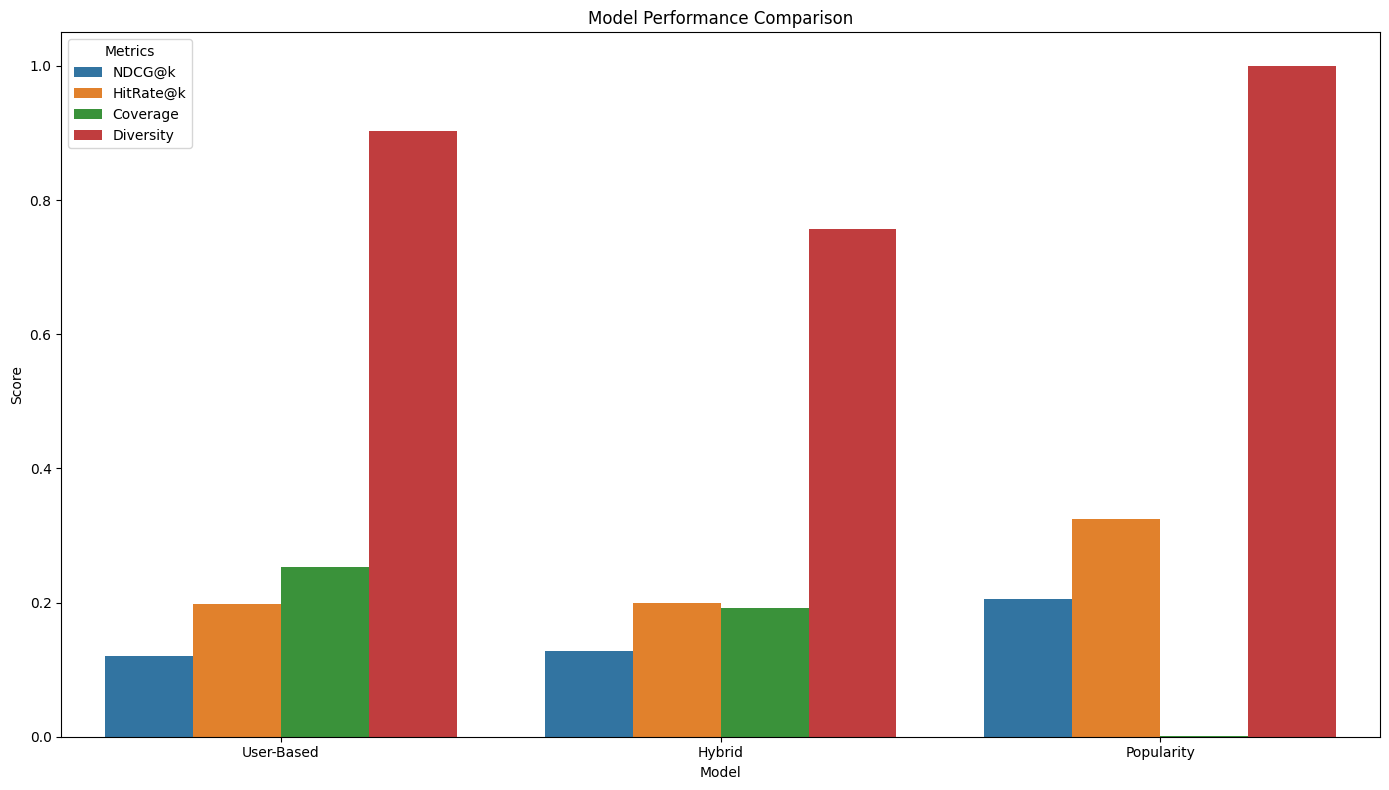

In [ ]:
#Bar graph showing comparison in model performance
metrics_ord = res_ord.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_ord)
plt.title('Model Performance Comparison')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

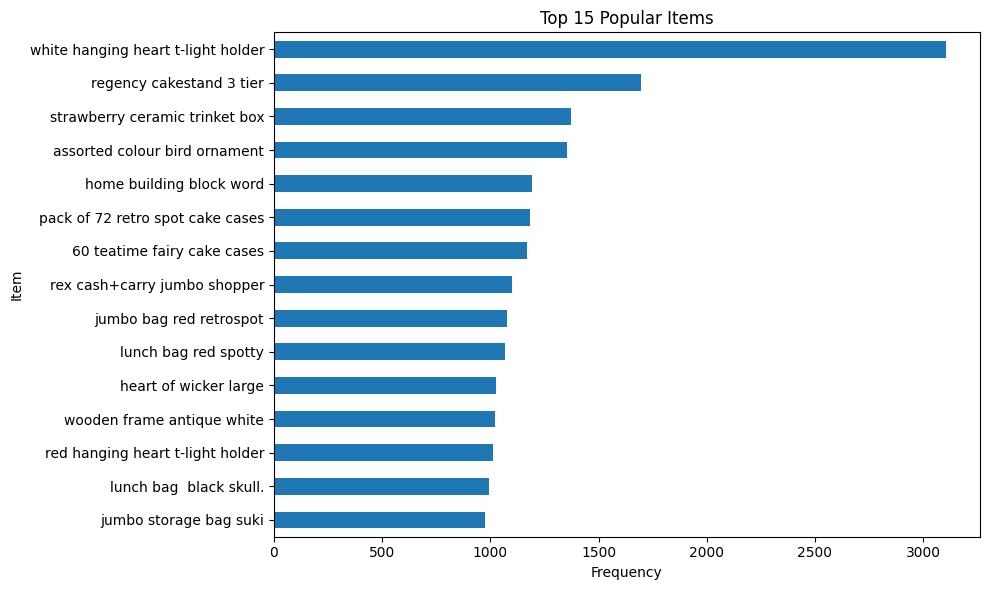

In [ ]:
#Top sold items in a bar graph
plt.figure(figsize=(10, 6))
ord['Item'].value_counts().head(15).plot.barh(title='Top 15 Popular Items')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

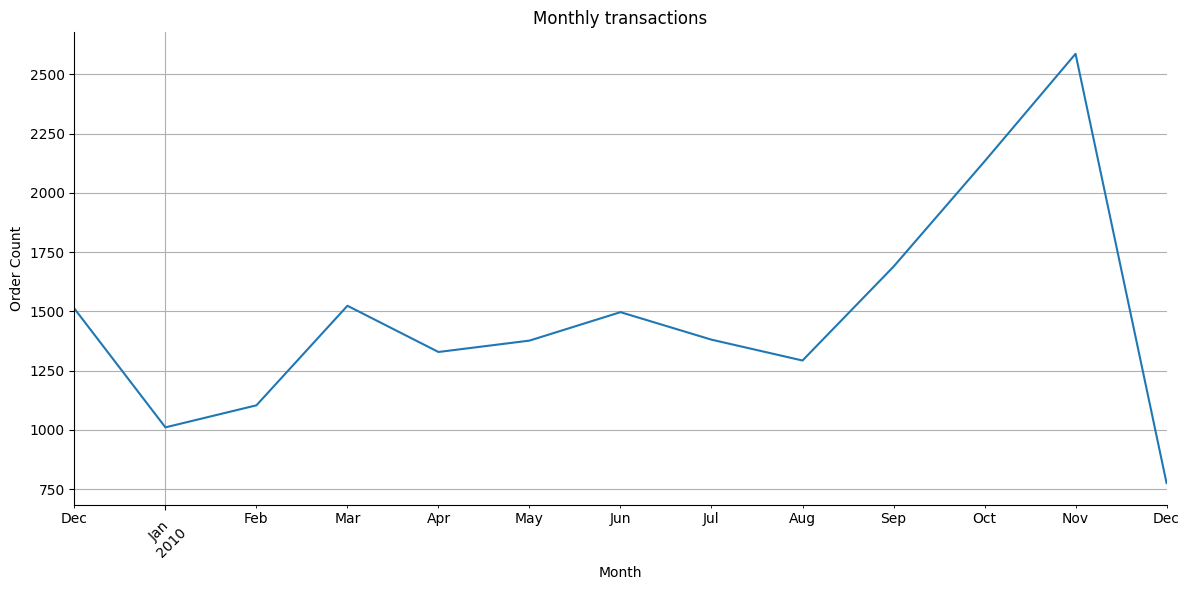

In [ ]:
#Monthly unique transaction volume
ord['Month'] = ord['InvoiceDate'].dt.to_period('M')
ord.groupby('Month')['Invoice'].nunique().plot(kind='line', figsize=(12,6))
plt.title('Monthly transactions')
plt.ylabel('Order Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
sns.despine()
plt.show()

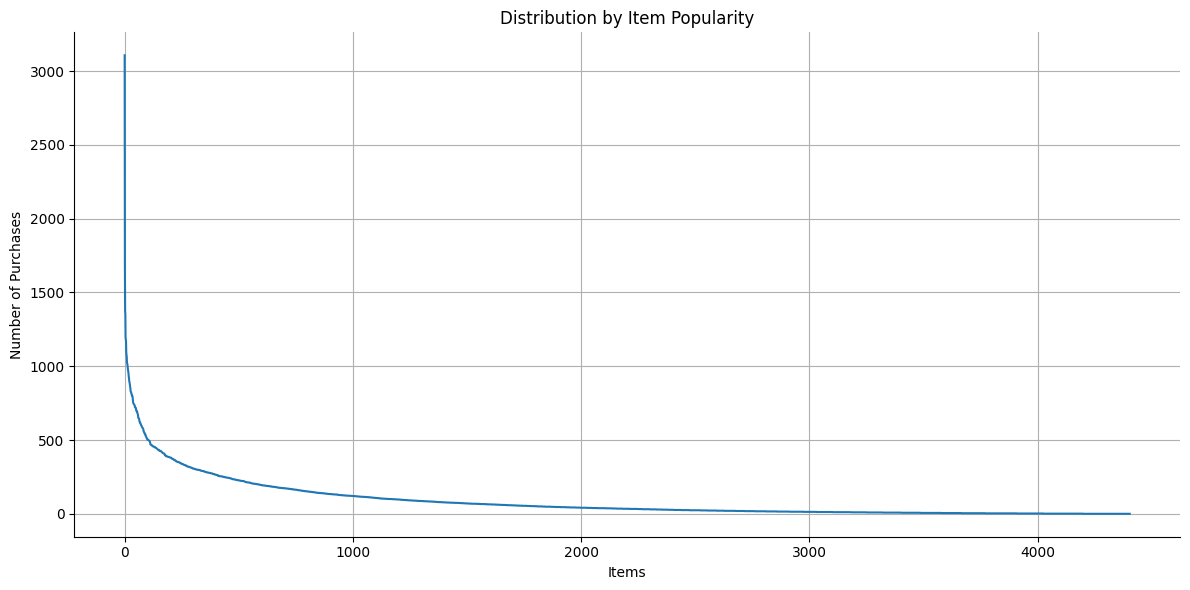

In [ ]:
#long tail distn. for item popularity
item_counts = ord['Item'].value_counts()
plt.figure(figsize=(12, 6))
plt.plot(item_counts.values)
plt.title('Distribution by Item Popularity')
plt.xlabel('Items')
plt.ylabel('Number of Purchases')
plt.grid(True)
sns.despine()
plt.tight_layout()
plt.show()

Thank you

Aniket Panda (GH1031696)